<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import spacy
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, silhouette_samples,adjusted_rand_score, homogeneity_score, completeness_score, davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# !python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

2022-10-17 15:31:09.070191: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 8.0 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [6]:
train = pd.read_csv('drive/Shareddrives/Milestone 2/Training_set.csv', 
                      sep='\t',index_col='ix')
train['lemmatized_text'] = train['lemmatized_text'].fillna('')
train['lemmatized_text'] = train['lemmatized_text'].astype(str)




sample_df = train.groupby('label').apply(lambda x: x.sample(5000, random_state=99))
sample_df.index = sample_df.index.get_level_values(1)
sample_df.head()

sample_df['embedding'] =  (sample_df['lemmatized_text']
                           .apply(lambda doc: nlp(doc).vector))

X = pd.DataFrame([x for x in sample_df['embedding']])



In [25]:


def find_best_dbscan(X,eps_lst, min_samp_lst):
  best_model = None 
  m = {'eps' : [],
       'min_samp' : [],
      'cluster':[],
       'score':[],
       'homogenity': [],
       'completeness': [],
        'davies_bouldin':[]}
  

  fig, ax = plt.subplots(4,4, figsize=(20,20))
  fig.suptitle('DBScan Clustering')
  ax = ax.flatten()

  ax_idx = 0
  for eps in eps_lst:
    for min_sample in min_samp_lst:
      dbscan = DBSCAN(eps=eps, min_samples=min_sample,
                      n_jobs=-1)
      cls = dbscan.fit_predict(X_std)
      
      # following code provided by https://machinelearningknowledge.ai/tutorial-for-dbscan-clustering-in-python-sklearn/
      clusters =dbscan.labels_
      num_clusters=len(set(clusters))-(1 if -1 in clusters else 0)
      
      
      
      score = silhouette_score(X_std,clusters,
                random_state=99)
      
      hg = homogeneity_score(sample_df.label, clusters)
      comp = completeness_score(sample_df.label, clusters)
      davies = davies_bouldin_score(X_std, clusters )

      m['eps'].append(eps)
      m['min_samp'].append(min_sample)
      

    
      m['cluster'].append(num_clusters)
      m['homogenity'].append(hg)
      m['completeness'].append(comp)
      m['davies_bouldin'].append(davies)


      scatter = ax[ax_idx].scatter(X_pca[:,0],X_pca[:,1], 
                                c=clusters,s=50, cmap='viridis')
      ax[ax_idx].set_title(f"k={num_clusters},eps={eps},min_samp={min_sample}")
      ax[ax_idx].set_xlabel("X0"); 
      ax[ax_idx].set_ylabel("X1")

      fig.colorbar(scatter, ax=ax[ax_idx])

      if best_model == None:
        best_model = dbscan
      elif score > np.max(m['score']):
        best_model = dbscan   
      m['score'].append(score)

      ax_idx += 1

    
  return m, best_model

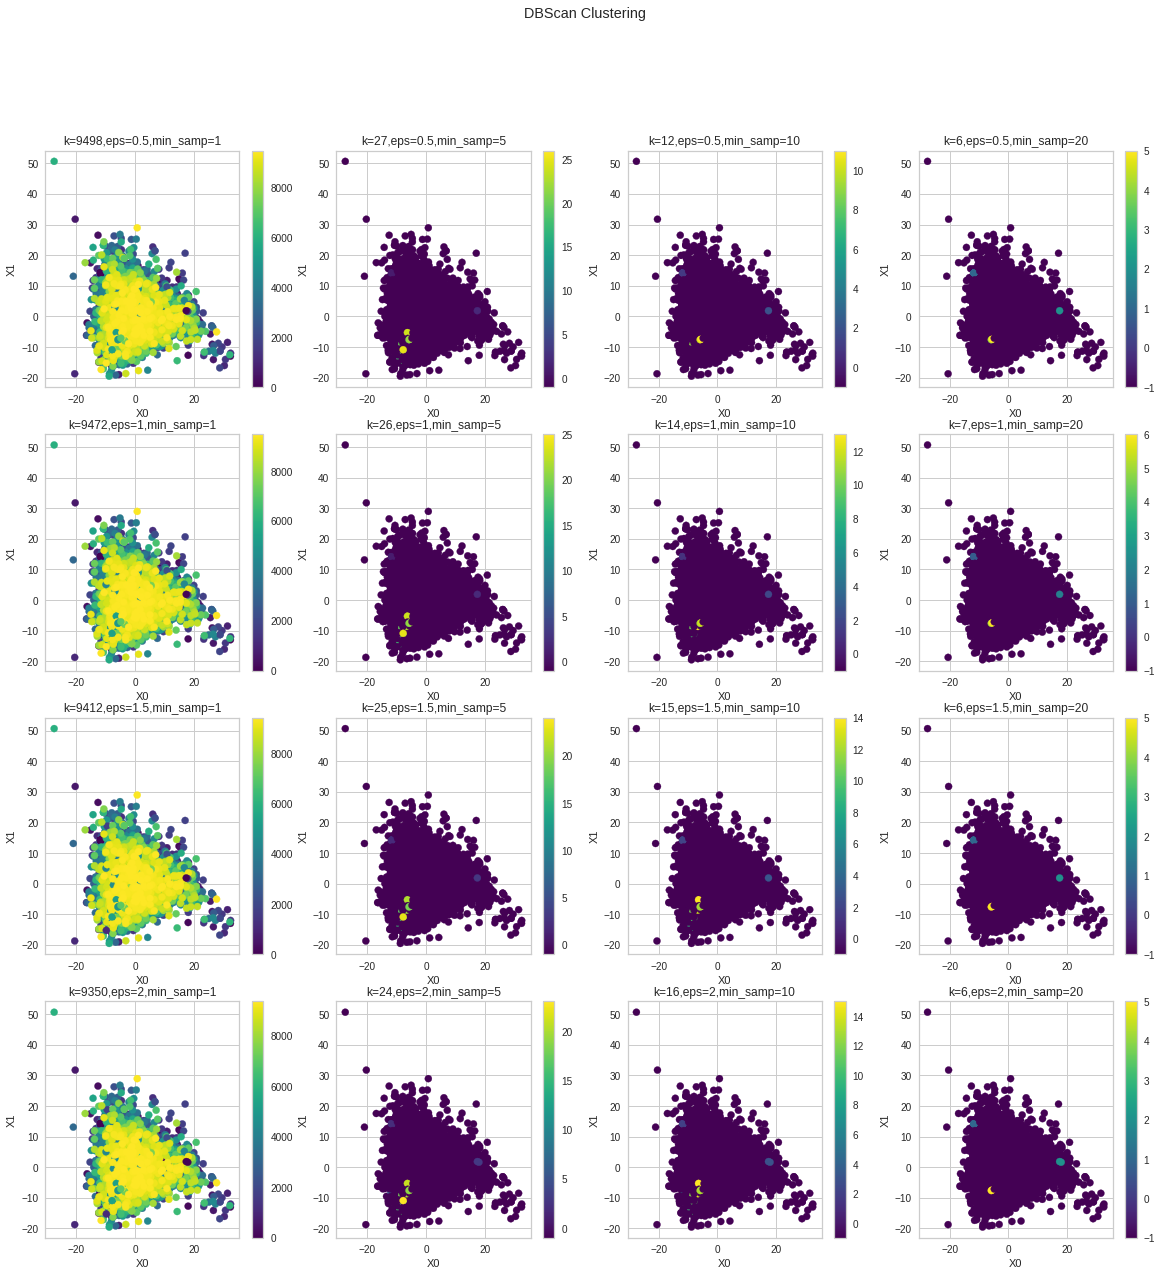

In [26]:
X_std = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_std)
results,db_scan_best_model = find_best_dbscan(X_std, [.5, 1, 1.5, 2], [1,5,10,20])

In [28]:
results_df = pd.DataFrame(results)

In [30]:
results_df.sort_values('score', ascending=False)

,eps,min_samp,cluster,score,homogenity,completeness,davies_bouldin
12,2.0,1,9350,0.079527,0.965546,0.073965,0.075140
8,1.5,1,9412,0.073599,0.973907,0.074488,0.051395
4,1.0,1,9472,0.071553,0.979631,0.074752,0.030852
0,0.5,1,9498,0.069554,0.982082,0.074881,0.014175
3,0.5,20,6,-0.102335,0.013296,0.083690,0.841823
7,1.0,20,7,-0.102938,0.015569,0.085498,0.869683
15,2.0,20,6,-0.141072,0.018957,0.090585,0.927166
11,1.5,20,6,-0.142260,0.018813,0.092259,0.923924
14,2.0,10,16,-0.155721,0.031247,0.090514,0.931539
10,1.5,10,15,-0.159113,0.029093,0.091212,0.922962
